In [1]:
from keras.api import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(1)

from keras.api import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras.api.utils import to_categorical

# Sentiment classification

In [2]:
model = models.Sequential()

model.add(layers.Input(shape=(52, 300), name="Domain_1"))

model.add(layers.Flatten())

model.add(layers.Dense(200, activation='relu', name="layer_1"))

model.add(layers.Dropout(0.8, name="dropout_3"))

model.add(layers.BatchNormalization(name="batch_normalization_3"))

model.add(layers.Dense(100, activation='relu', name="layer_2"))

model.add(layers.Dropout(0.8, name="dropout_4"))

model.add(layers.BatchNormalization(name="batch_normalization_4"))

model.add(layers.Dense(3, activation='softmax', name="sentiment"))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2025-02-15 22:27:40.074864: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-02-15 22:27:40.074895: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-15 22:27:40.074902: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1739654860.075328 4048176 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1739654860.075645 4048176 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 15600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 200)            │     3,120,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sentiment (Dense)               │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,141,803 (11.99 MB)

 Trainable params: 3,141,203 (11.98 MB)

 Non-trainable params: 600 (2.34 KB)

In [3]:
df_original = pd.read_csv("data/processed/processed_tweets.csv")

In [4]:
df_with_unlabeled = df_original.copy()
df_with_unlabeled = df_with_unlabeled[df_with_unlabeled["Sentiment"].isna()]
df_original = df_original.dropna(subset=["Sentiment"])
df_original.info()

df_original["Sentiment"] = df_original["Sentiment"].map({-1: 0, 0: 1, 1: 2})

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           400 non-null    object 
 1   Sentiment      400 non-null    float64
 2   Has opinion    400 non-null    float64
 3   cleaned_text   400 non-null    object 
 4   word_vectors   400 non-null    object 
 5   glove_vectors  400 non-null    object 
dtypes: float64(2), object(4)
memory usage: 21.9+ KB


In [5]:
df_original["Sentiment"].value_counts()

Sentiment
0    243
1    133
2     24
Name: count, dtype: int64

In [6]:
padded_vectors_glove = np.load("data/processed/padded_glove_vectors.npy")
padded_vectors_word2vec = np.load("data/processed/padded_word_2_vec_vectors.npy")
padded_vectors_glove = padded_vectors_glove[:400]
padded_vectors_word2vec = padded_vectors_word2vec[:400]

padded_vectors_combined = np.concatenate([padded_vectors_glove, padded_vectors_word2vec], axis=1)

In [7]:
padded_vectors_glove.shape

(400, 26, 300)

In [8]:
padded_vectors_combined.shape

(400, 52, 300)

one hot encoding

In [9]:
X_train, X_test, y_train, y_test = train_test_split(padded_vectors_combined, df_original["Sentiment"], test_size=0.2, random_state=1, stratify=df_original["Sentiment"])
# y_train_encoded = to_categorical(y_train, num_classes=3)
# y_test_encoded = to_categorical(y_test, num_classes=3)

In [10]:
# y_train_encoded

In [11]:
unique_values, counts = np.unique(y_train, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 195
1: 106
2: 19


In [12]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 48
1: 27
2: 5


In [13]:
history = model.fit(x=X_train, y=y_train, epochs=50)

Epoch 1/50


2025-02-15 22:27:49.405938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3263 - loss: 1.5941
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3384 - loss: 1.4773
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4082 - loss: 1.4507
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4475 - loss: 1.3022
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4506 - loss: 1.1983
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4276 - loss: 1.2537
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4926 - loss: 1.0841
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5189 - loss: 1.0868
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5256 - loss: 0.9795
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5004 - loss: 1.0707
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5503 - loss: 0.9605
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5555 - l

In [14]:
model.save("models/experiment_3_sentiment_classification_model.keras")

Text(0.5, 0, 'epoch')

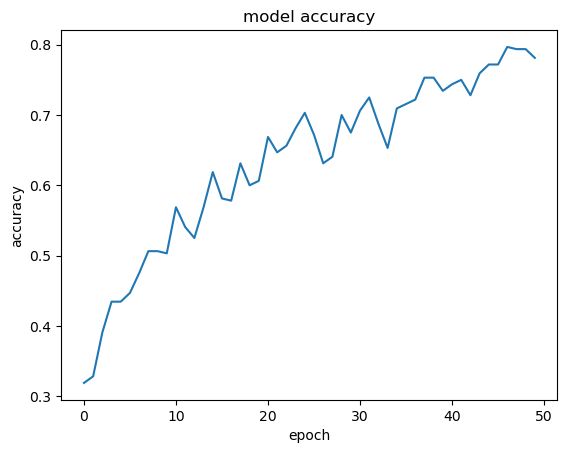

In [15]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

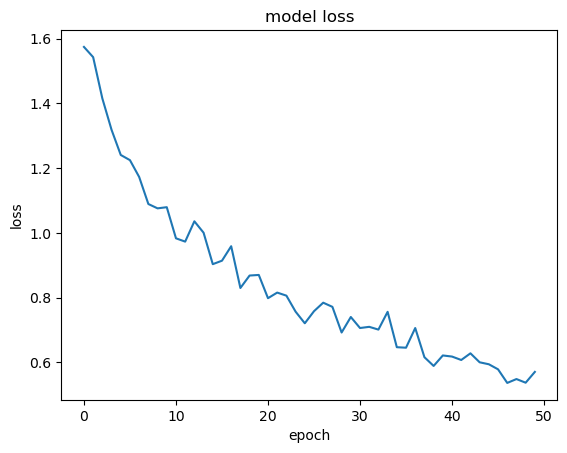

In [16]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [17]:
evaluation = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {evaluation[0]}, accuracy: {evaluation[1]}')

Loss: 0.805651068687439, accuracy: 0.6625000238418579


In [18]:
predictions = model.predict(X_test).argmax(axis=1)
print("Unique values in predictions:", np.unique(predictions))

print("Unique values in y_test:", np.unique(y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Unique values in predictions: [0 1]
Unique values in y_test: [0 1 2]


[[47  1  0]
 [21  6  0]
 [ 5  0  0]]


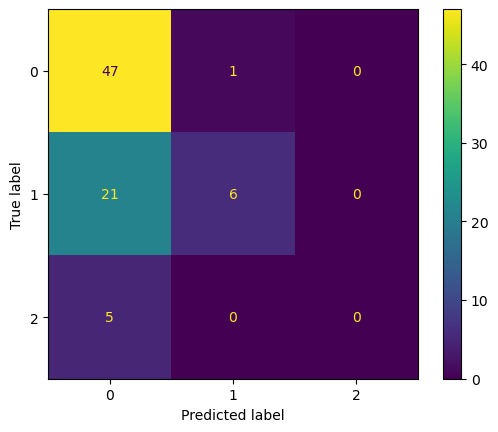

In [19]:
matrix = confusion_matrix(y_test, predictions)
print(matrix)
display = ConfusionMatrixDisplay(matrix)
display.plot()

# Opinion detection

In [20]:
model = models.Sequential()

model.add(layers.Input(shape=(52, 300), name="Domain_1"))

model.add(layers.Flatten())

model.add(layers.Dense(200, activation='relu', name="layer_1"))

model.add(layers.Dropout(0.8, name="dropout_3"))

model.add(layers.BatchNormalization(name="batch_normalization_3"))

model.add(layers.Dense(100, activation='relu', name="layer_2"))

model.add(layers.Dropout(0.8, name="dropout_4"))

model.add(layers.BatchNormalization(name="batch_normalization_4"))

model.add(layers.Dense(1, activation='sigmoid', name="opinion"))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 15600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 200)            │     3,120,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ opinion (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,141,601 (11.98 MB)

 Trainable params: 3,141,001 (11.98 MB)

 Non-trainable params: 600 (2.34 KB)

In [21]:
df_original = pd.read_csv("data/processed/processed_tweets.csv")

In [22]:
df_with_unlabeled = df_original.copy()
df_with_unlabeled = df_with_unlabeled[df_with_unlabeled["Has opinion"].isna()]
df_original = df_original.dropna(subset=["Has opinion"])
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           400 non-null    object 
 1   Sentiment      400 non-null    float64
 2   Has opinion    400 non-null    float64
 3   cleaned_text   400 non-null    object 
 4   word_vectors   400 non-null    object 
 5   glove_vectors  400 non-null    object 
dtypes: float64(2), object(4)
memory usage: 21.9+ KB


In [23]:
df_original["Has opinion"].value_counts()

Has opinion
0.0    209
1.0    191
Name: count, dtype: int64

In [24]:
padded_vectors_glove = np.load("data/processed/padded_glove_vectors.npy")
padded_vectors_word2vec = np.load("data/processed/padded_word_2_vec_vectors.npy")
padded_vectors_glove = padded_vectors_glove[:400]
padded_vectors_word2vec = padded_vectors_word2vec[:400]

padded_vectors_combined = np.concatenate([padded_vectors_glove, padded_vectors_word2vec], axis=1)

In [25]:
padded_vectors_combined.shape

(400, 52, 300)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(padded_vectors_combined, df_original["Has opinion"], test_size=0.2, random_state=1)
# y_train_encoded = to_categorical(y_train, num_classes=2)
# y_test_encoded = to_categorical(y_test, num_classes=2)

In [27]:
history = model.fit(x=X_train, y=y_train, epochs=50)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5012 - loss: 0.8878 - precision: 0.4704 - recall: 0.5049
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5832 - loss: 0.7752 - precision: 0.5542 - recall: 0.5422
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5558 - loss: 0.7986 - precision: 0.5252 - recall: 0.5351
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6018 - loss: 0.7306 - precision: 0.5757 - recall: 0.5759
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6038 - loss: 0.7592 - precision: 0.5750 - recall: 0.5847
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6253 - loss: 0.6858 - precision: 0.6050 - recall: 0.5800
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6845 - loss: 0.6131 - precision: 0.6677 - recall: 0.6450
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6634 - loss: 0.6604 - precision: 0.6391 - recall: 0.6458
Epoch 9/50
10/10 ━━━━━━━

In [28]:
model.save("models/experiment_3_opinion_detection_model.keras")

Text(0.5, 0, 'epoch')

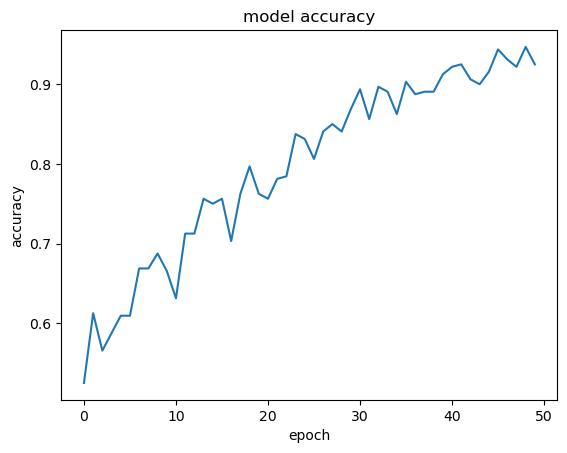

In [29]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

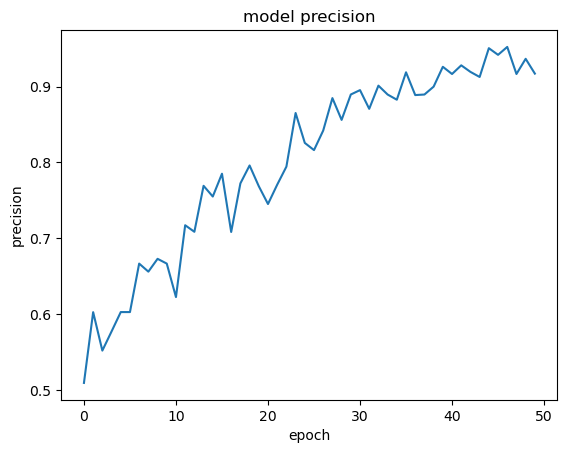

In [30]:
plt.plot(history.history['precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

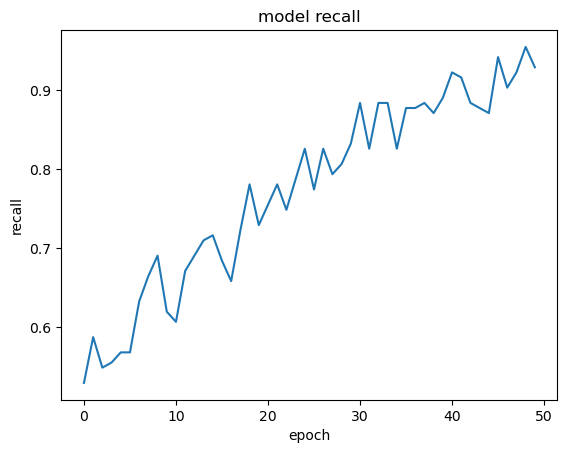

In [31]:
plt.plot(history.history['recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

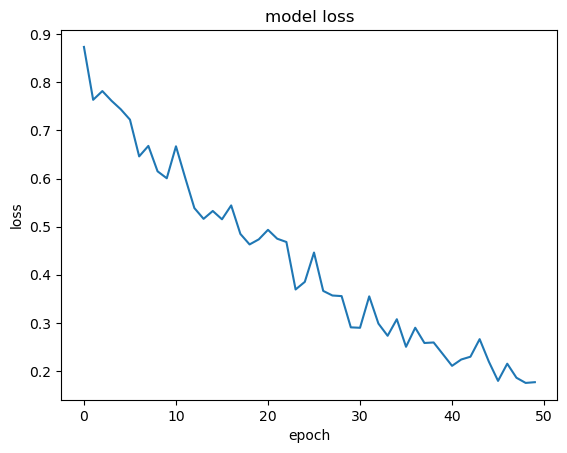

In [32]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [33]:
evaluation = model.evaluate(X_test, y_test)
print(f'Loss: {evaluation[0]}, accuracy: {evaluation[1]}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6555 - loss: 0.7804 - precision: 0.5650 - recall: 0.6724
Loss: 0.7613334059715271, accuracy: 0.6625000238418579


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


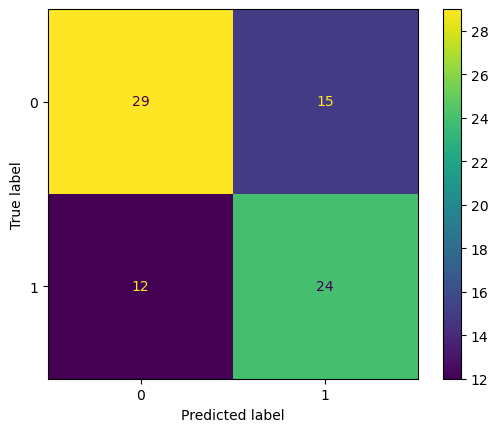

In [34]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
matrix = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(matrix)
display.plot()